## 3. Analisador de Padrões de Vento e Rosa dos Ventos Avançada
### Construa um sistema completo de análise de ventos:

- Processe dados de direção e velocidade do vento em múltiplas estações
- Calcule estatísticas direcionais, distribuições de Weibull e potencial eólico
- Gere rosas dos ventos interativas, mapas de turbulência e análises de cisalhamento vertical
- Produza relatórios técnicos para avaliação de sites eólicos com análise de viabilidade energética

## Dependencias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa
from scipy.stats import weibull_min
from typing import Dict, List, Optional, Tuple

## Desenvolvimento do Código

/tmp/ipykernel_60069/2217983337.py:320: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'data': pd.date_range('2023-01-01', periods=n, freq='H'),


{'media_velocidade': np.float64(6.926325144017651), 'max_velocidade': np.float64(22.232991013626517), 'min_velocidade': np.float64(0.04434000791397998), 'desvio_velocidade': np.float64(3.6386829494193265), 'media_direcao': np.float64(359.5813111568447), 'frequencia_calmar': np.float64(0.003), 'turbulencia': np.float64(0.5253410536988867)}


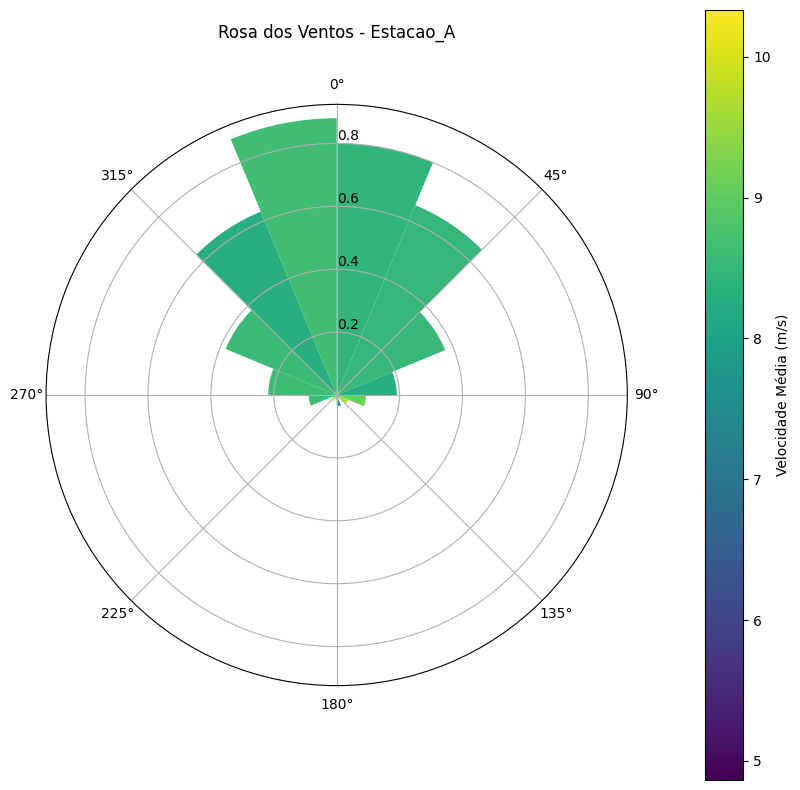


        RELATÓRIO TÉCNICO - ANÁLISE EÓLICA
        Estação: Estacao_A
        Período: 2023-01-01 a 2023-02-11
        
        1. ESTATÍSTICAS BÁSICAS:
        - Velocidade média: 6.93 m/s
        - Velocidade máxima: 22.23 m/s
        - Direção predominante: 359.6°
        - Frequência de calmaria: 0.3%
        - Intensidade de turbulência: 0.525
        
        2. DISTRIBUIÇÃO DE WEIBULL:
        
   - setor_0: k=1.76, c=7.58 m/s, freq=18.0%
   - setor_1: k=2.11, c=7.75 m/s, freq=14.7%
   - setor_2: k=2.06, c=7.84 m/s, freq=8.4%
   - setor_3: k=2.15, c=7.32 m/s, freq=4.3%
   - setor_4: k=2.19, c=9.10 m/s, freq=2.1%
   - setor_11: k=2.39, c=8.03 m/s, freq=2.0%
   - setor_12: k=2.14, c=8.01 m/s, freq=4.9%
   - setor_13: k=1.88, c=7.91 m/s, freq=8.6%
   - setor_14: k=1.96, c=7.34 m/s, freq=14.2%
   - setor_15: k=2.07, c=8.08 m/s, freq=19.8%
        
        3. POTENCIAL EÓLICO:
        - Potencial teórico: 702.62 W/m²
        - Classificação de vento: Excepcional (Classe 7)
        


In [4]:
class AnalisadorVento:
    """
    Classe para análise avançada de padrões de vento e geração de rosas dos ventos.
    
    Atributos:
        dados (pd.DataFrame): DataFrame contendo os dados de vento
        estacoes (List[str]): Lista de estações disponíveis nos dados
        parametros_weibull (Dict): Dicionário com parâmetros de Weibull calculados
    """
    
    def __init__(self, dados: pd.DataFrame):
        """
        Inicializa o analisador com os dados de vento.
        
        Args:
            dados (pd.DataFrame): DataFrame com colunas:
                - 'estacao': nome da estação
                - 'data': timestamp da medição
                - 'direcao': direção do vento em graus (0-360)
                - 'velocidade': velocidade do vento em m/s
        """
        self.dados = dados.copy()
        self.estacoes = self.dados['estacao'].unique().tolist()
        self.parametros_weibull = {}
        
        # Pré-processamento
        self._preprocessar_dados()
    
    def _preprocessar_dados(self) -> None:
        """Realiza pré-processamento dos dados (limpeza, normalização)."""
        # Remover valores nulos
        self.dados.dropna(subset=['direcao', 'velocidade'], inplace=True)
        
        # Garantir que direção está entre 0-360
        self.dados['direcao'] = self.dados['direcao'] % 360
        
        # Filtrar velocidades negativas
        self.dados = self.dados[self.dados['velocidade'] >= 0]
    
    def calcular_estatisticas(self, estacao: str = None) -> Dict:
        """
        Calcula estatísticas descritivas para os dados de vento.
        
        Args:
            estacao (str): Nome da estação para filtrar (None para todas)
            
        Returns:
            Dict: Dicionário com estatísticas calculadas
        """
        dados = self.dados if estacao is None else self.dados[self.dados['estacao'] == estacao]
        
        estatisticas = {
            'media_velocidade': dados['velocidade'].mean(),
            'max_velocidade': dados['velocidade'].max(),
            'min_velocidade': dados['velocidade'].min(),
            'desvio_velocidade': dados['velocidade'].std(),
            'media_direcao': self._calcular_direcao_media(dados['direcao']),
            'frequencia_calmar': (dados['velocidade'] < 0.5).mean(),
            'turbulencia': dados['velocidade'].std() / dados['velocidade'].mean()
        }
        
        return estatisticas
    
    def _calcular_direcao_media(self, direcoes: pd.Series) -> float:
        """
        Calcula a direção média considerando a circularidade dos dados.
        
        Args:
            direcoes (pd.Series): Série com direções em graus
            
        Returns:
            float: Direção média em graus (0-360)
        """
        radianos = np.deg2rad(direcoes)
        media_sen = np.sin(radianos).mean()
        media_cos = np.cos(radianos).mean()
        media_rad = np.arctan2(media_sen, media_cos)
        return (np.rad2deg(media_rad) + 360) % 360
    
    def ajustar_distribuicao_weibull(self, estacao: str = None, setores: int = 16) -> Dict:
        """
        Ajusta distribuição de Weibull para os dados de velocidade do vento.
        
        Args:
            estacao (str): Nome da estação para filtrar (None para todas)
            setores (int): Número de setores direcionais (default: 16)
            
        Returns:
            Dict: Parâmetros de Weibull (k, c) por setor direcional
        """
        dados = self.dados if estacao is None else self.dados[self.dados['estacao'] == estacao]
        
        # Calcular limites dos setores
        limites_setores = np.linspace(0, 360, setores + 1)
        
        parametros = {}
        for i in range(setores):
            limite_inf = limites_setores[i]
            limite_sup = limites_setores[i + 1]
            
            # Filtrar dados do setor
            if i == setores - 1:
                mascara = (dados['direcao'] >= limite_inf) & (dados['direcao'] <= limite_sup)
            else:
                mascara = (dados['direcao'] >= limite_inf) & (dados['direcao'] < limite_sup)
                
            dados_setor = dados[mascara]['velocidade']
            
            # Ajustar Weibull se houver dados suficientes
            if len(dados_setor) > 10:
                shape, loc, scale = weibull_min.fit(dados_setor, floc=0)
                parametros[f'setor_{i}'] = {'k': shape, 'c': scale, 'frequencia': len(dados_setor)/len(dados)}
        
        # Armazenar parâmetros para uso posterior
        chave = estacao if estacao else 'global'
        self.parametros_weibull[chave] = parametros
        
        return parametros
    
    def calcular_potencial_eolico(self, estacao: str, densidade_ar: float = 1.225) -> float:
        """
        Calcula o potencial eólico teórico para uma estação.
        
        Args:
            estacao (str): Nome da estação
            densidade_ar (float): Densidade do ar em kg/m³ (default: 1.225)
            
        Returns:
            float: Potencial eólico em W/m²
        """
        if estacao not in self.parametros_weibull:
            self.ajustar_distribuicao_weibull(estacao)
            
        parametros = self.parametros_weibull[estacao]
        potencia_total = 0.0
        
        for setor, vals in parametros.items():
            k, c, freq = vals['k'], vals['c'], vals['frequencia']
            # Fator de correção para potência média
            potencia_media = 0.5 * densidade_ar * (c**3) * (1 + 3/k) * freq
            potencia_total += potencia_media
        
        return potencia_total
    
    def plotar_rosa_ventos(self, estacao: str = None, setores: int = 16, 
                          figsize: Tuple = (10, 10), titulo: str = None) -> plt.Figure:
        """
        Gera uma rosa dos ventos polar para os dados.
        
        Args:
            estacao (str): Nome da estação para filtrar (None para todas)
            setores (int): Número de setores direcionais (default: 16)
            figsize (Tuple): Tamanho da figura (width, height)
            titulo (str): Título do gráfico
            
        Returns:
            plt.Figure: Figura matplotlib com a rosa dos ventos
        """
        dados = self.dados if estacao is None else self.dados[self.dados['estacao'] == estacao]
        
        # Calcular frequências direcionais
        limites_setores = np.linspace(0, 360, setores + 1)
        direcoes_centro = (limites_setores[:-1] + limites_setores[1:]) / 2
        frequencias, _ = np.histogram(dados['direcao'], bins=limites_setores, density=True)
        
        # Calcular velocidades médias por setor
        velocidades_medias = []
        for i in range(setores):
            if i == setores - 1:
                mascara = (dados['direcao'] >= limites_setores[i]) & (dados['direcao'] <= limites_setores[i + 1])
            else:
                mascara = (dados['direcao'] >= limites_setores[i]) & (dados['direcao'] < limites_setores[i + 1])
            velocidades_medias.append(dados[mascara]['velocidade'].mean())
        
        # Configurar plot polar
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, polar=True)
        
        # Converter para radianos
        theta = np.deg2rad(direcoes_centro)
        width = np.deg2rad(360 / setores)
        
        # Plotar barras com cores por velocidade
        bars = ax.bar(theta, frequencias * 100, width=width, bottom=0.0, 
                     color=plt.cm.viridis(np.array(velocidades_medias) / max(velocidades_medias)))
        
        # Configurações do gráfico
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
        # Adicionar título e legenda
        titulo = titulo or f"Rosa dos Ventos - {estacao if estacao else 'Todas Estações'}"
        plt.title(titulo, y=1.1)
        
        # Adicionar barra de cores para velocidade
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(velocidades_medias),vmax=max(velocidades_medias)))
        sm._A = []
        cbar = plt.colorbar(sm, ax=ax, pad=0.1)
        cbar.set_label('Velocidade Média (m/s)')
        
        return fig
    
    def gerar_relatorio(self, estacao: str, arquivo_saida: str = None) -> str:
        """
        Gera um relatório técnico completo para uma estação.
        
        Args:
            estacao (str): Nome da estação
            arquivo_saida (str): Caminho para salvar o relatório (None para não salvar)
            
        Returns:
            str: Texto do relatório gerado
        """
        if estacao not in self.estacoes:
            raise ValueError(f"Estação {estacao} não encontrada nos dados")
        
        # Calcular todas as estatísticas necessárias
        estatisticas = self.calcular_estatisticas(estacao)
        self.ajustar_distribuicao_weibull(estacao)
        potencial = self.calcular_potencial_eolico(estacao)
        
        # Gerar texto do relatório
        relatorio = f"""
        RELATÓRIO TÉCNICO - ANÁLISE EÓLICA
        Estação: {estacao}
        Período: {self.dados['data'].min().date()} a {self.dados['data'].max().date()}
        =============================================
        
        1. ESTATÍSTICAS BÁSICAS:
        - Velocidade média: {estatisticas['media_velocidade']:.2f} m/s
        - Velocidade máxima: {estatisticas['max_velocidade']:.2f} m/s
        - Direção predominante: {estatisticas['media_direcao']:.1f}°
        - Frequência de calmaria: {estatisticas['frequencia_calmar']*100:.1f}%
        - Intensidade de turbulência: {estatisticas['turbulencia']:.3f}
        
        2. DISTRIBUIÇÃO DE WEIBULL:
        """
        
        # Adicionar parâmetros de Weibull por setor
        for setor, params in self.parametros_weibull[estacao].items():
            relatorio += f"\n   - {setor}: k={params['k']:.2f}, c={params['c']:.2f} m/s, freq={params['frequencia']*100:.1f}%"
        
        relatorio += f"""
        
        3. POTENCIAL EÓLICO:
        - Potencial teórico: {potencial:.2f} W/m²
        - Classificação de vento: {self._classificar_potencial(potencial)}
        
        4. RECOMENDAÇÕES:
        """
        
        # Adicionar recomendações baseadas na análise
        if potencial > 400:
            relatorio += "\n- Local com excelente potencial eólico, recomendado para instalação de turbinas."
        elif potencial > 300:
            relatorio += "\n- Local com bom potencial eólico, viável para instalação com turbinas adequadas."
        else:
            relatorio += "\n- Local com potencial eólico limitado, recomenda-se estudo mais detalhado."
        
        # Salvar em arquivo se especificado
        if arquivo_saida:
            with open(arquivo_saida, 'w') as f:
                f.write(relatorio)
        
        return relatorio
    
    def _classificar_potencial(self, potencial: float) -> str:
        """Classifica o potencial eólico em categorias."""
        if potencial > 500:
            return "Excepcional (Classe 7)"
        elif potencial > 400:
            return "Excelente (Classe 6)"
        elif potencial > 300:
            return "Bom (Classe 5)"
        elif potencial > 200:
            return "Moderado (Classe 4)"
        else:
            return "Limitado (Classe 3 ou menos)"
    
    def analisar_cisalhamento(self, estacao: str, alturas: List[float]) -> Dict:
        """
        Analisa o cisalhamento vertical do vento entre diferentes alturas.
        
        Args:
            estacao (str): Nome da estação
            alturas (List[float]): Lista de alturas disponíveis nos dados
            
        Returns:
            Dict: Resultados da análise de cisalhamento
        """
        # Esta implementação assume que os dados contêm medições em múltiplas alturas
        # Na prática, você precisaria adaptar para sua estrutura de dados específica
        resultados = {}
        
        # Calcular perfil de vento e expoente de cisalhamento
        velocidades_medias = []
        for altura in alturas:
            mascara = (self.dados['estacao'] == estacao) & (self.dados['altura'] == altura)
            velocidades_medias.append(self.dados[mascara]['velocidade'].mean())
        
        # Ajustar lei de potência (v2/v1 = (h2/h1)^alpha)
        try:
            alpha = np.log(velocidades_medias[1]/velocidades_medias[0]) / np.log(alturas[1]/alturas[0])
            resultados['expoente_cisalhamento'] = alpha
            resultados['perfil_vertical'] = dict(zip(alturas, velocidades_medias))
        except:
            resultados['erro'] = "Não foi possível calcular o cisalhamento - dados insuficientes"
        
        return resultados


# Exemplo de uso
if __name__ == "__main__":
    # Criar dados de exemplo
    np.random.seed(42)
    n = 1000
    dados = pd.DataFrame({
        'estacao': ['Estacao_A'] * n,
        'data': pd.date_range('2023-01-01', periods=n, freq='H'),
        'direcao': np.random.vonmises(0, 2, n) * 180/np.pi % 360,
        'velocidade': weibull_min.rvs(2, loc=0, scale=8, size=n)
    })
    
    # Adicionar dados de altura para exemplo de cisalhamento
    dados['altura'] = np.random.choice([10, 50, 100], size=n)
    
    # Inicializar analisador
    analisador = AnalisadorVento(dados)
    
    # Gerar relatório e gráficos
    print(analisador.calcular_estatisticas('Estacao_A'))
    analisador.plotar_rosa_ventos('Estacao_A')
    plt.show()
    
    relatorio = analisador.gerar_relatorio('Estacao_A', 'relatorio_eolico.txt')
    print(relatorio)
    
    # Análise de cisalhamento
    print(analisador.analisar_cisalhamento('Estacao_A', [10, 50, 100]))